In [12]:
%matplotlib inline

import matplotlib as mpl
import networkx as nx
import numpy as np
import random
import pandas as pd
import math
from copy import copy
from collections import defaultdict
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

from graph_generator import grid_2d, add_p_and_delta
from simulations import sample_graph_from_infection, simulate_IC, make_input
from plot_utils import plot_snapshot
from utils import infeciton_time2weight
from synthetic_data import (load_data_by_gtype, GRID, KRONECKER_HIER, KRONECKER_PERI, KRONECKER_RAND,
                            PL_TREE, ER, BARABASI, CLIQUE)

In [13]:
gtype = CLIQUE
g, times_by_source, source2nodeid_counter = load_data_by_gtype(gtype)
u, v = next(g.edges_iter())
infp = g[u][v]['p']
print('infp = {}'.format(infp))
if gtype == GRID:
    pos = {n: np.array(n) for n in g.nodes()}
else:
    pos = nx.spring_layout(g)

infp = 0.7


In [14]:
N = 5000
source, obs_nodes, infection_times, tree = make_input(g, infp, 0.05, sampling_method='late_nodes')
times_list = []
node2id = {n: i for i, n in enumerate(g.nodes())}

for i in range(N):
    sampled_g = sample_graph_from_infection(g)
    times, tree = simulate_IC(sampled_g, s=source, is_g_sampled=True)
    times = [times[n] for n in g.nodes()]
    times_list.append(times) 
    
times_array = np.array(times_list)    

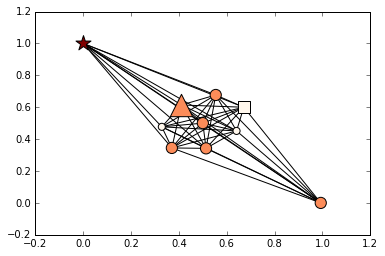

In [15]:
node2weight = infeciton_time2weight(infection_times)

plot_snapshot(g, pos, node2weight, 
              query_node=0,
              source_node=source,
              queried_nodes=obs_nodes, 
              max_node_size=500)

In [16]:
def extract_non_inf(arr):
    return arr[np.invert(np.isinf(arr))]

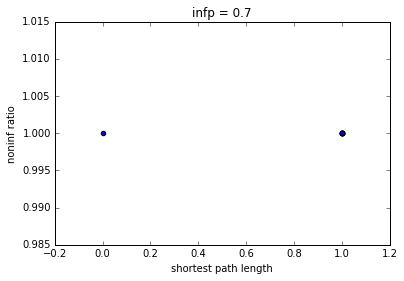

In [17]:
sp_len = nx.shortest_path_length(g, source=source)
lens = list(map(sp_len.__getitem__, g.nodes()))
noninf_ratio = list(map(lambda n: np.count_nonzero(np.invert(np.isinf(times_array[:, node2id[n]]))) / N, g.nodes()))
plt.scatter(lens, noninf_ratio)
plt.xlabel('shortest path length')
plt.ylabel('noninf ratio')
plt.title('infp = {}'.format(infp))

source=6


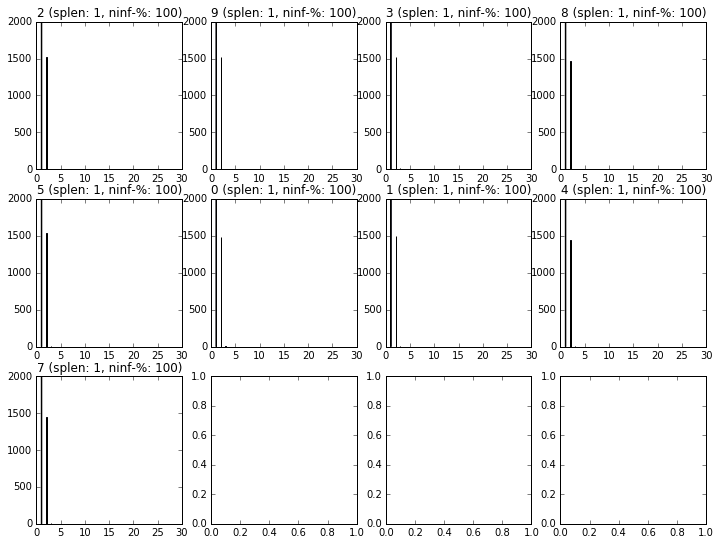

In [18]:
plot_cnts = 40

if plot_cnts > g.number_of_nodes() - 1:
    plot_cnts = g.number_of_nodes() - 1
w = 3
ncol = 4
nrow = math.ceil(plot_cnts / ncol)
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * w, nrow * w))
sampled_nodes = random.sample(list(set(g.nodes()) - {source}), plot_cnts)

sampled_nodes = sorted(sampled_nodes, key=sp_len.__getitem__)
print('source={}'.format(source))
for n, c in zip(sampled_nodes, range(plot_cnts)):
    i, j = int(c / ncol), c % ncol
    if nrow > 1:
        ax = axes[i][j]
    else:
        ax = axes[c]
    pts = extract_non_inf(times_array[:, node2id[n]])
    ax.hist(pts, bins=20)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 2000)
    ax.set_title('{} (splen: {}, ninf-%: {:.0f})'.format(n, sp_len[n], len(pts) / N * 100))